# MLP from scratch

In this homework, you will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify text data.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check about `torch.clamp`, `torch.nn.Parameter`

## 1. Some utilities and dataset for Part 2

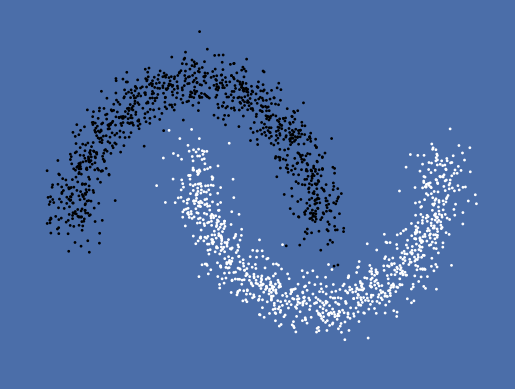

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plot the dataset
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=2000, noise=0.1)

%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

In [ ]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting
  
    Z = classifier.predict(to_forward)
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    
    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X,Y)

In [ ]:
# define some utility functions

!pip install terminaltables
from __future__ import print_function, division
from terminaltables import AsciiTable
import numpy as np


def to_categorical(x, n_col=None):
    """ One-hot encoding of nominal values """
    if not n_col:
        n_col = np.amax(x) + 1
    one_hot = np.zeros((x.shape[0], n_col))
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot

def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

def batch_iterator(X, y=None, batch_size=64):
    """ Simple batch generator """
    n_samples = X.shape[0]
    for i in np.arange(0, n_samples, batch_size):
        begin, end = i, min(i+batch_size, n_samples)
        if y is not None:
            yield X[begin:end], y[begin:end]
        else:
            yield X[begin:end]

def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test

def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

In [ ]:
class MyReLU(object):
    def __call__(self, x):
        # the relu is y_i = max(0, x_i)
        # YOUR CODE HERE
        return np.where(x >= 0, x, 0)

    def forward(self, x):
        # the relu is y_i = max(0, x_i)
        # YOUR CODE HERE
        return np.where(x >= 0, x, 0)
        
    def backward(self, grad_output):
        # the gradient is 1 for the inputs that were above 0, 0 elsewhere
        # YOUR CODE HERE
        return np.where(grad_output >= 0, 1, 0)
    
    def step(self, learning_rate):
        # no need to do anything here, since ReLU has no parameters
        # YOUR CODE HERE
        raise NotImplementedError()

class MySigmoid(object):
    def __call__(self, x):
        # the relu is y_i = max(0, x_i)
        # YOUR CODE HERE
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        # the relu is y_i = max(0, x_i)
        # YOUR CODE HERE
        return 1 / (1 + np.exp(-x))
        
    
    def backward(self, grad_output):
        # the gradient is 1 for the inputs that were above 0, 0 elsewhere
        # YOUR CODE HERE
        return self.forward(grad_output) * (1 - self.forward(grad_output))
    
    def step(self, learning_rate):
        # no need to do anything here, since ReLU has no parameters
        # YOUR CODE HERE
        raise NotImplementedError()

Probably a good time to test your functions...

In [ ]:
test_relu = MyReLU()
test_relu.forward(np.array([0, -1, 0.5, -0.5, 0.8, 1]))

array([0. , 0. , 0.5, 0. , 0.8, 1. ])

In [ ]:
test_relu.backward(np.ones(1))

array([1])

In [ ]:
test_sig = MySigmoid()

test_sig.forward(np.ones(1))

array([0.73105858])

In [ ]:
test_sig.backward(np.ones(1))

array([0.19661193])

A bit more complicated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.

In [ ]:
class Layer(object):

    def set_input_shape(self, shape):
        """ Sets the shape that the layer expects of the input in the forward
        pass method """
        self.input_shape = shape

    def layer_name(self):
        """ The name of the layer. Used in model summary. """
        return self.__class__.__name__

    def parameters(self):
        """ The number of trainable parameters used by the layer """
        return 0

    def forward_pass(self, X, training):
        """ Propogates the signal forward in the network """
        raise NotImplementedError()

    def backward_pass(self, accum_grad):
        """ Propogates the accumulated gradient backwards in the network.
        If the has trainable weights then these weights are also tuned in this method.
        As input (accum_grad) it receives the gradient with respect to the output of the layer and
        returns the gradient with respect to the output of the previous layer. """
        raise NotImplementedError()

    def output_shape(self):
        """ The shape of the output produced by forward_pass """
        raise NotImplementedError()


In [ ]:
import math
import numpy as np
import copy


class MyLinear(Layer):
    """A fully-connected NN layer.
    Parameters:
    -----------
    n_units: int
        The number of neurons in the layer.
    input_shape: tuple
        The expected input shape of the layer. For dense layers a single digit specifying
        the number of features of the input. Must be specified if it is the first layer in
        the network.
    """
    def __init__(self, n_units, input_shape=None):
        # initialize two random matrices for W and b (use np.random.randn)
        # YOUR CODE HERE
        self.layer_input = None
        self.input_shape = input_shape
        self.n_units = n_units
        self.trainable = True
        self.W = None
        self.w0 = None

    def initialize(self, optimizer):
        # Initialize the weights
        # YOUR CODE HERE
        limit = 1 / math.sqrt(self.input_shape[0])
        self.W  = np.random.uniform(-limit, limit, (self.input_shape[0], self.n_units))
        self.w0 = np.zeros((1, self.n_units))
        # Weight optimizers
        self.W_opt  = copy.copy(optimizer)
        self.w0_opt = copy.copy(optimizer)

    def parameters(self):
        return np.prod(self.W.shape) + np.prod(self.w0.shape)

    def forward_pass(self, X, training=True):
        # save a copy of x, you'll need it for the backward
        # return Wx + b
        # YOUR CODE HERE
        self.layer_input = X
        return X.dot(self.W) + self.w0

    def backward_pass(self, accum_grad):
        # Save weights used during forwards pass
        W = self.W

        if self.trainable:
            # Calculate gradient w.r.t layer weights
            # y_i = \sum_j W_{i,j} x_j + b_i
            # d y_i / d W_{i, j} = x_j
            # d loss / d y_i = grad_output[i]
            # so d loss / d W_{i,j} = x_j * grad_output[i]  (by the chain rule)
            # YOUR CODE HERE
            grad_w = self.layer_input.T.dot(accum_grad)
            grad_w0 = np.sum(accum_grad, axis=0, keepdims=True)

            # Update the layer weights
            # self.W = self.W_opt.update(self.W, grad_w)
            # self.w0 = self.w0_opt.update(self.w0, grad_w0)
            self.W , self.w0 = self.step(grad_w, grad_w0)

        # Return accumulated gradient for next layer
        # Calculated based on the weights used during the forward pass
        accum_grad = accum_grad.dot(W.T)
        return accum_grad

    def output_shape(self):
        return (self.n_units, )
        
    def step(self, grad_w, grad_w0 ,learning_rate=0.001,):
        # YOUR CODE HERE
        # update self.W and self.b in the opposite direction of the stored gradients, for learning_rate
        W = self.W_opt.update(self.W, grad_w)
        w0 = self.w0_opt.update(self.w0, grad_w0)

        return W, w0
    


In [ ]:
class Flatten(Layer):
    """ Turns a multidimensional matrix into two-dimensional """
    def __init__(self, input_shape=None):
        self.prev_shape = None
        self.trainable = True
        self.input_shape = input_shape

    def forward_pass(self, X, training=True):
        self.prev_shape = X.shape
        return X.reshape((X.shape[0], -1))

    def backward_pass(self, accum_grad):
        return accum_grad.reshape(self.prev_shape)

    def output_shape(self):
        return (np.prod(self.input_shape),)

In [ ]:

class CrossEntropy():
    def __init__(self): pass

    def loss(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def acc(self, y, p):
        return accuracy_score(np.argmax(y, axis=1), np.argmax(p, axis=1))

    def gradient(self, y, p):
        # Avoid division by zero
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p)


In [ ]:
class Activation(Layer):
    """A layer that applies an activation operation to the input.

    Parameters:
    -----------
    name: string
        The name of the activation function that will be used.
    """

    def __init__(self, name):
        self.activation_name = name
        self.activation_func = activation_functions[name]()
        self.trainable = True

    def layer_name(self):
        return "Activation (%s)" % (self.activation_func.__class__.__name__)

    def forward_pass(self, X, training=True):
        self.layer_input = X
        return self.activation_func(X)

    def backward_pass(self, accum_grad):
        return accum_grad * self.activation_func.backward(self.layer_input)

    def output_shape(self):
        return self.input_shape

In [ ]:
class Adam():
    def __init__(self, learning_rate=0.001, b1=0.9, b2=0.999):
        self.learning_rate = learning_rate
        self.eps = 1e-8
        self.m = None
        self.v = None
        # Decay rates
        self.b1 = b1
        self.b2 = b2

    def update(self, w, grad_wrt_w):
        # If not initialized
        if self.m is None:
            self.m = np.zeros(np.shape(grad_wrt_w))
            self.v = np.zeros(np.shape(grad_wrt_w))
        
        self.m = self.b1 * self.m + (1 - self.b1) * grad_wrt_w
        self.v = self.b2 * self.v + (1 - self.b2) * np.power(grad_wrt_w, 2)

        m_hat = self.m / (1 - self.b1)
        v_hat = self.v / (1 - self.b2)

        self.w_updt = self.learning_rate * m_hat / (np.sqrt(v_hat) + self.eps)

        return w - self.w_updt


Code your network. Note that with a Sigmoid layer, you should use the Binary Cross Entropy (BCE) loss.

In [ ]:
from tqdm import tqdm

class Sequential():
    """Neural Network. Deep Learning base model.

    Parameters:
    -----------
    optimizer: class
        The weight optimizer that will be used to tune the weights in order of minimizing
        the loss.
    loss: class
        Loss function used to measure the model's performance. SquareLoss or CrossEntropy.
    validation: tuple
        A tuple containing validation data and labels (X, y)
    """
    def __init__(self, optimizer, loss, validation_data=None):
        # Specify your model's Architecture here (Use your Linear and Activation Functions)
        # YOUR CODE HERE
        self.optimizer = optimizer
        self.layers = []
        self.errors = {"training": [], "validation": []}
        # use the BCE loss
        # -(label * log(output) + (1-label) * log(1-output))
        # save the gradient, and return the loss      
        # beware of dividing by zero in the gradient.
        # split the computation in two cases, one where the label is 0 and another one where the label is 1
        # add a small value (1e-10) to the denominator
        # YOUR CODE HERE
        self.loss_function = loss()
        # self.progressbar = progressbar.ProgressBar(widgets=bar_widgets)

        self.val_set = None
        if validation_data:
            X, y = validation_data
            self.val_set = {"X": X, "y": y}

    def set_trainable(self, trainable):
        """ Method which enables freezing of the weights of the network's layers. """
        for layer in self.layers:
            layer.trainable = trainable

    def add(self, layer):
        """ Method which adds a layer to the neural network """
        # If this is not the first layer added then set the input shape
        # to the output shape of the last added layer
        if self.layers:
            layer.set_input_shape(shape=self.layers[-1].output_shape())

        # If the layer has weights that needs to be initialized 
        if hasattr(layer, 'initialize'):
            layer.initialize(optimizer=self.optimizer)

        # Add layer to the network
        self.layers.append(layer)

    def test_on_batch(self, X, y):
        """ Evaluates the model over a single batch of samples """
        y_pred = self._forward_pass(X, training=False)
        loss = np.mean(self.loss_function.loss(y, y_pred))
        acc = self.loss_function.acc(y, y_pred)

        return loss, acc

    def train_on_batch(self, X, y):
        """ Single gradient update over one batch of samples """
        y_pred = self._forward_pass(X)
        loss = np.mean(self.loss_function.loss(y, y_pred))
        acc = self.loss_function.acc(y, y_pred)
        # Calculate the gradient of the loss function wrt y_pred
        loss_grad = self.loss_function.gradient(y, y_pred)
        # Backpropagate. Update weights
        self._backward_pass(loss_grad=loss_grad)

        return loss, acc

    def fit(self, X, y, n_epochs, batch_size):
        """ Trains the model for a fixed number of epochs """
        for _ in tqdm(range(n_epochs)):
            
            batch_error = []
            for X_batch, y_batch in batch_iterator(X, y, batch_size=batch_size):
                loss, _ = self.train_on_batch(X_batch, y_batch)
                batch_error.append(loss)

            self.errors["training"].append(np.mean(batch_error))

            if self.val_set is not None:
                val_loss, _ = self.test_on_batch(self.val_set["X"], self.val_set["y"])
                self.errors["validation"].append(val_loss)

        return self.errors["training"], self.errors["validation"]

    def _forward_pass(self, X, training=True):
        # YOUR CODE HERE
        """ Calculate the output of the NN """
        layer_output = X
        for layer in self.layers:
            layer_output = layer.forward_pass(layer_output, training)

        return layer_output

    def _backward_pass(self, loss_grad):
        # apply backprop sequentially, starting from the gradient of the loss
        # YOUR CODE HERE
        """ Propagate the gradient 'backwards' and update the weights in each layer """
        for layer in reversed(self.layers):
            loss_grad = layer.backward_pass(loss_grad)

    def summary(self, name="Model Summary"):
        # Print model name
        print (AsciiTable([[name]]).table)
        # Network input shape (first layer's input shape)
        print ("Input Shape: %s" % str(self.layers[0].input_shape))
        # Iterate through network and get each layer's configuration
        table_data = [["Layer Type", "Parameters", "Output Shape"]]
        tot_params = 0
        for layer in self.layers:
            layer_name = layer.layer_name()
            params = layer.parameters()
            out_shape = layer.output_shape()
            table_data.append([layer_name, str(params), str(out_shape)])
            tot_params += params
        # Print network configuration table
        print (AsciiTable(table_data).table)
        print ("Total Parameters: %d\n" % tot_params)

    def predict(self, X):
        """ Use the trained model to predict labels of X """
        return self._forward_pass(X, training=False)


+-----+
| MLP |
+-----+
Input Shape: 2
+------------------------+------------+--------------+
| Layer Type             | Parameters | Output Shape |
+------------------------+------------+--------------+
| Flatten                | 0          | (2,)         |
| MyLinear               | 6          | (2,)         |
| Activation (MySigmoid) | 0          | (2,)         |
+------------------------+------------+--------------+
Total Parameters: 6



100%|██████████| 100/100 [00:01<00:00, 90.83it/s]


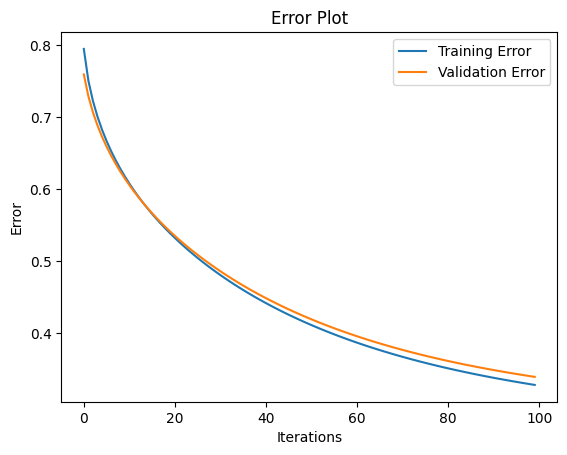

Accuracy: 0.845


In [ ]:
# define your network with your Sequential Class
# YOUR CODE HERE
import copy
activation_functions = {
    'relu': MyReLU,
    'sigmoid': MySigmoid,
}

optimizer = Adam()

y = to_categorical(Y.astype("int"))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, seed=1)

clf = Sequential(optimizer=optimizer,
                    loss=CrossEntropy,
                  validation_data=(X_test, y_test))

clf.add(Flatten(input_shape=(2)))
clf.add(MyLinear(2))
clf.add(Activation('sigmoid'))

print ()
clf.summary(name="MLP")

train_err, val_err = clf.fit(X, y, n_epochs=100, batch_size=32)

# Training and validation error plot
%matplotlib inline
n = len(train_err)
training, = plt.plot(range(n), train_err, label="Training Error")
validation, = plt.plot(range(n), val_err, label="Validation Error")
plt.legend(handles=[training, validation])
plt.title("Error Plot")
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.show()

_, accuracy = clf.test_on_batch(X_test, y_test)
print ("Accuracy:", accuracy)



# raise NotImplementedError()



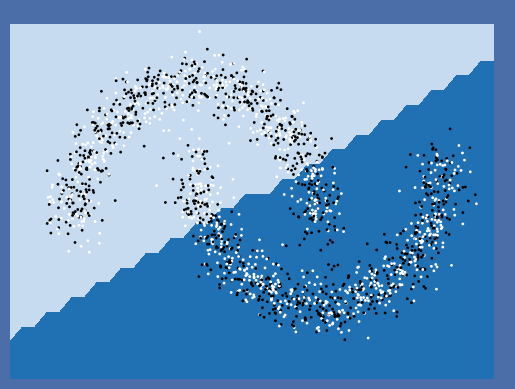

In [ ]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, np.argmax(y, axis=1), clf)
fig.canvas.draw()

## 3. Using a Pytorch module

In this last part, use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

## 3.1. Load & Preprocess the IMDB Dataset

In this section, you are required to read and load the provided `csv` file, and perform the preprocessing steps as specified in the assignment's description.

In [ ]:
# download data
! gdown --id 1ohmmz5Gz-2Pz1cV4T1nYIHxGjQ_I_U5B

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ohmmz5Gz-2Pz1cV4T1nYIHxGjQ_I_U5B
To: /content/imdb_dataset.csv
100% 66.2M/66.2M [00:00<00:00, 80.3MB/s]


In [ ]:
import pandas as pd
import re
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report

In [ ]:
movie_reviews = pd.read_csv('/content/imdb_dataset.csv')

In [ ]:
movie_reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
# Looking for one review example
movie_reviews['review'].loc[345]

'Incomprehensibly dreadful mishmash of the probably most notorious of all Roman emperors who went insane, leaving infamous party orgies and ruthless killings in his path... I know there are several versions of this, and this is based on the 102 min\' one that I watched - but I can\'t fathom how that possibly can make any difference to lift the rest of this movie out of the muck!<br /><br />I\'d heard for long about the alleged "shocking" content of sex/nudity (which honestly there isn\'t much of here at all - and boring when there is) and blood, but beware - it\'s the technical production amateurishness that well and truly shocks here: Everything looks plain and simply like a junior film school flunk project! Camera-work is hopelessly inept, full of strange zooms, failed framing and confusing pans (to and from what mostly looks like a huge theater stage!) complete with a grainy, cheapish photo quality. Lighting and color schemes are terrible and uneven - is it day or night? Are they in

In [ ]:
# Downloading Stop Words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

<Axes: xlabel='sentiment', ylabel='count'>

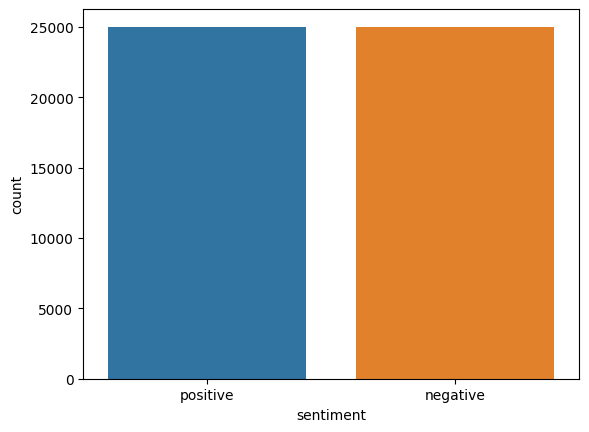

In [ ]:
sns.countplot(x='sentiment',data=movie_reviews)

In [ ]:
# Calling portstemmer for the purpose of stemming the words in review
ps = PorterStemmer()

In [ ]:
corpus = []
for i in range(0,len(movie_reviews)):
    review = re.sub('[^a-zA-Z]',' ',movie_reviews['review'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
# Creating a bag of words model
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(max_features=3000)
x = cv.fit_transform(corpus).toarray()

In [ ]:
y = pd.get_dummies(movie_reviews['sentiment'])
y = y.iloc[:,1].values

In [ ]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=0)

## 3.2. MLP in torch

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [ ]:
import torch
import torch.nn as nn
import math

In [ ]:
# Define your dataloader here (specify your batch_size)
# Use:
from torch.utils.data import TensorDataset, DataLoader
# Note that you should transform your X, y to torch.Tensor

from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
dataset_test = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))


dataLoader_train = DataLoader(dataset_train, batch_size = 1024)
dataLoader_test = DataLoader(dataset_test)

In [ ]:
from torch import Tensor
from torch.nn import Parameter
import torch.nn.functional as F

class MyLinear(nn.Module):


    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

class MyReLU(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, input: Tensor):
        return F.relu(input)

# **Learning Rate = 0.001**

In [ ]:
import torch
import torch.nn as nn
import math

model = nn.Sequential(
    MyLinear(3000, 8000),
    MyReLU(),
    MyLinear(8000, 5000),
    MyReLU(),
    MyLinear(5000, 500),
    MyReLU(),
    MyLinear(500, 1),

    nn.Sigmoid()
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

!pip install torchsummary
from torchsummary import summary

summary(model, (1024, 3000))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          MyLinear-1           [-1, 1024, 8000]      24,008,000
            MyReLU-2           [-1, 1024, 8000]               0
          MyLinear-3           [-1, 1024, 5000]      40,005,000
            MyReLU-4           [-1, 1024, 5000]               0
          MyLinear-5            [-1, 1024, 500]       2,500,500
            MyReLU-6            [-1, 1024, 500]               0
          MyLinear-7              [-1, 1024, 1]             501
           Sigmoid-8              [-1, 1024, 1]               0
Total params: 66,514,001
Trainable params: 66,514,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 11.72
Forward/backward pass size (MB): 210.95
Params size (MB): 253.73
Estimated Total Size (MB): 47

In [ ]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.optimizer import Optimizer
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import classification_report
from torch import optim

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()



def train_classifier_epoch(model: torch.nn.Module,
                            optimizer: Optimizer,
                            train_dataloader: DataLoader,
                            val_dataloader: DataLoader
                            ):
  train_loss_list = []
  val_loss_list = []


  train_acc_list = []
  val_acc_list = []

  epoch_count = 5

# You can print epoch No. and train/test accuracy here (after each epoch)

  for i in range(epoch_count):
      print(100*"-")
      print(f'Epoch: {i}')
      t_losses, t_true, t_pred = [], [], []
      v_losses, v_true, v_pred = [], [], []

      # do a forward pass on the batch
      # YOUR CODE HERE
      model.train()
      for x, y in tqdm(dataLoader_train):
          x = x.to(device)
          y = y.to(device)
          optimizer.zero_grad()
          preds = model(x)

          # compute the loss according to your output and the label
          # YOUR CODE HERE
          loss = loss_fn(preds.squeeze(1), y)


          # backward pass
          # YOUR CODE HERE
          loss.backward()

          # gradient step
          # YOUR CODE HERE
          optimizer.step()
          t_losses.append(loss.item())

          t_true.append(y.cpu().detach().numpy())
          t_pred.append(preds.squeeze(1).cpu().detach().numpy())

      # zero the gradients
      # YOUR CODE HERE
      with torch.no_grad():
          model.eval()
          for val_x, val_y in tqdm(dataLoader_test):
              val_x = val_x.to(device)
              val_y = val_y.to(device)
              val_preds = model(val_x)
              val_loss = loss_fn(val_preds.squeeze(1), val_y)
              v_losses.append(val_loss.item())

              v_true.append(val_y.cpu().detach().numpy())
              v_pred.append(val_preds.squeeze(1).cpu().detach().numpy())

      train_auc = roc_auc_score(np.concatenate(t_true), np.concatenate(t_pred))
      val_auc = roc_auc_score(np.concatenate(v_true), np.concatenate(v_pred))


      
      train_accuracy = accuracy_score(np.concatenate(t_true), np.concatenate(t_pred).round())
      val_accuracy = accuracy_score(np.concatenate(v_true), np.concatenate(v_pred).round())
      report = classification_report(np.concatenate(v_true), np.concatenate(v_pred).round())

      train_loss_list.append(np.mean(t_losses))
      train_acc_list.append(np.mean(train_accuracy))
      val_loss_list.append(np.mean(v_losses))
      val_acc_list.append(val_accuracy)

      print()
      print(f'Train loss: {np.mean(t_losses)}, Train AUC ROC: {train_auc}, Train Accuracy: {np.mean(train_accuracy)}')
      print()
      print(f'Val loss: {np.mean(v_losses)}, Val AUC ROC: {val_auc}, Val Accuracy: {val_accuracy}')
      print(100*"-")


  print("Classification Report:",report)

  return train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [ ]:


train_loss_list, val_loss_list, train_acc_list, val_acc_list  = train_classifier_epoch(model, optimizer, dataLoader_train, dataLoader_test)

----------------------------------------------------------------------------------------------------
Epoch: 0


100%|██████████| 12500/12500 [00:23<00:00, 524.06it/s]



Train loss: 0.3942649533619752, Train AUC ROC: 0.902709602004881, Train Accuracy: 0.80984

Val loss: 0.28630812076350265, Val AUC ROC: 0.9501635001560004, Val Accuracy: 0.87848
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 1


100%|██████████| 12500/12500 [00:21<00:00, 580.88it/s]



Train loss: 0.219389362109674, Train AUC ROC: 0.9702821462593076, Train Accuracy: 0.9116533333333333

Val loss: 0.3442124044513096, Val AUC ROC: 0.9508526178112139, Val Accuracy: 0.86736
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 2


100%|██████████| 12500/12500 [00:17<00:00, 711.59it/s]



Train loss: 0.08830387744347791, Train AUC ROC: 0.9942303041454685, Train Accuracy: 0.9730133333333333

Val loss: 0.5974430548828757, Val AUC ROC: 0.945214986403639, Val Accuracy: 0.82784
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 3


100%|██████████| 12500/12500 [00:17<00:00, 704.91it/s]



Train loss: 0.029379183376157605, Train AUC ROC: 0.9992176033700728, Train Accuracy: 0.9909333333333333

Val loss: 0.6106581247384562, Val AUC ROC: 0.9436672205977044, Val Accuracy: 0.86992
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 4


100%|██████████| 12500/12500 [00:17<00:00, 709.16it/s]



Train loss: 0.06618630198912846, Train AUC ROC: 0.9971569286280448, Train Accuracy: 0.9744533333333333

Val loss: 0.5875069134482893, Val AUC ROC: 0.9482343931395807, Val Accuracy: 0.87872
----------------------------------------------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

         0.0       0.87      0.89      0.88      6291
         1.0       0.89      0.86      0.88      6209

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



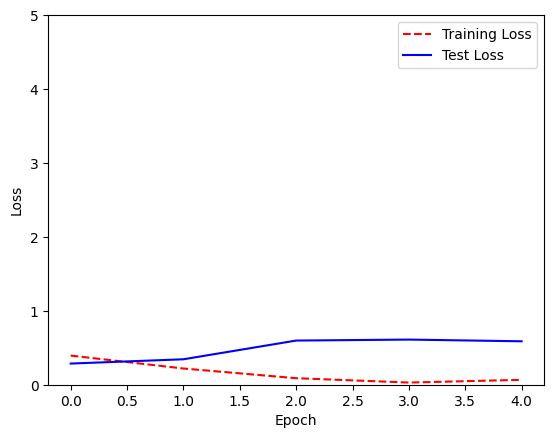

In [ ]:
import matplotlib.pyplot as plt

# Visualize loss history
plt.plot(range(len(train_loss_list)), np.array(train_loss_list), 'r--')
plt.plot(range(len(val_loss_list)), np.array(val_loss_list), 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 5)
plt.show()

# plt.plot(train_loss_list)
# plt.plot(val_loss_list)

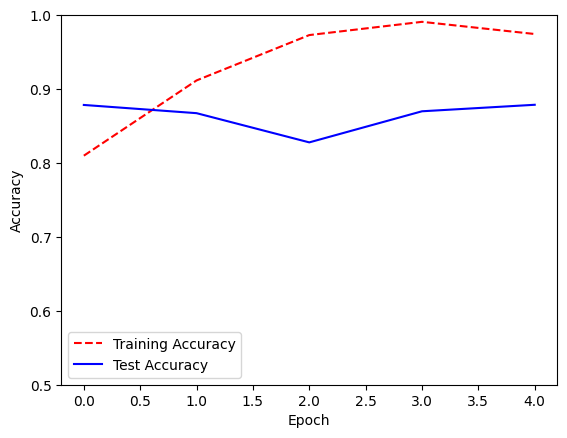

In [ ]:
plt.plot(range(len(train_acc_list)), np.array(train_acc_list), 'r--')
plt.plot(range(len(val_acc_list)), np.array(val_acc_list), 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)
plt.show()


# **Learning Rate = 0.01**

In [ ]:
import torch
import torch.nn as nn
import math

model = nn.Sequential(
    MyLinear(3000, 8000),
    MyReLU(),
    MyLinear(8000, 5000),
    MyReLU(),
    MyLinear(5000, 500),
    MyReLU(),
    MyLinear(500, 1),

    nn.Sigmoid()
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


summary(model, (1024, 3000))

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

train_loss_list, val_loss_list, train_acc_list, val_acc_list  = train_classifier_epoch(model, optimizer, dataLoader_train, dataLoader_test)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          MyLinear-1           [-1, 1024, 8000]      24,008,000
            MyReLU-2           [-1, 1024, 8000]               0
          MyLinear-3           [-1, 1024, 5000]      40,005,000
            MyReLU-4           [-1, 1024, 5000]               0
          MyLinear-5            [-1, 1024, 500]       2,500,500
            MyReLU-6            [-1, 1024, 500]               0
          MyLinear-7              [-1, 1024, 1]             501
           Sigmoid-8              [-1, 1024, 1]               0
Total params: 66,514,001
Trainable params: 66,514,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 11.72
Forward/backward pass size (MB): 210.95
Params size (MB): 253.73
Estimated Total Size (MB): 476.40
----------------------------------------------------------------
-----------------------------

100%|██████████| 12500/12500 [00:17<00:00, 713.68it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 46.297709735664164, Train AUC ROC: 0.5000366892420968, Train Accuracy: 0.49733333333333335

Val loss: 50.328, Val AUC ROC: 0.5, Val Accuracy: 0.49672
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 1


100%|██████████| 12500/12500 [00:17<00:00, 703.95it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 49.88856588827597, Train AUC ROC: 0.5, Train Accuracy: 0.5010933333333333

Val loss: 50.328, Val AUC ROC: 0.5, Val Accuracy: 0.49672
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 2


100%|██████████| 12500/12500 [00:17<00:00, 708.66it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 49.88856588827597, Train AUC ROC: 0.5, Train Accuracy: 0.5010933333333333

Val loss: 50.328, Val AUC ROC: 0.5, Val Accuracy: 0.49672
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 3


100%|██████████| 12500/12500 [00:17<00:00, 709.11it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 49.88856588827597, Train AUC ROC: 0.5, Train Accuracy: 0.5010933333333333

Val loss: 50.328, Val AUC ROC: 0.5, Val Accuracy: 0.49672
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 4


100%|██████████| 12500/12500 [00:17<00:00, 698.00it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 49.88856588827597, Train AUC ROC: 0.5, Train Accuracy: 0.5010933333333333

Val loss: 50.328, Val AUC ROC: 0.5, Val Accuracy: 0.49672
----------------------------------------------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      6291
         1.0       0.50      1.00      0.66      6209

    accuracy                           0.50     12500
   macro avg       0.25      0.50      0.33     12500
weighted avg       0.25      0.50      0.33     12500



# **Activation Functions**

# **Sigmoid**

In [ ]:
import torch
import torch.nn as nn
import math

model = nn.Sequential(
    MyLinear(3000, 8000),
    nn.Sigmoid(),
    MyLinear(8000, 5000),
    nn.Sigmoid(),
    MyLinear(5000, 500),
    nn.Sigmoid(),
    MyLinear(500, 1),

    nn.Sigmoid()
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


summary(model, (1024, 3000))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

train_loss_list, val_loss_list, train_acc_list, val_acc_list  = train_classifier_epoch(model, optimizer, dataLoader_train, dataLoader_test)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          MyLinear-1           [-1, 1024, 8000]      24,008,000
           Sigmoid-2           [-1, 1024, 8000]               0
          MyLinear-3           [-1, 1024, 5000]      40,005,000
           Sigmoid-4           [-1, 1024, 5000]               0
          MyLinear-5            [-1, 1024, 500]       2,500,500
           Sigmoid-6            [-1, 1024, 500]               0
          MyLinear-7              [-1, 1024, 1]             501
           Sigmoid-8              [-1, 1024, 1]               0
Total params: 66,514,001
Trainable params: 66,514,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 11.72
Forward/backward pass size (MB): 210.95
Params size (MB): 253.73
Estimated Total Size (MB): 476.40
----------------------------------------------------------------
-----------------------------

100%|██████████| 12500/12500 [00:17<00:00, 711.42it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 0.8354083509058565, Train AUC ROC: 0.50347465910301, Train Accuracy: 0.5018933333333333

Val loss: 0.6943903763628005, Val AUC ROC: 0.5184315771771195, Val Accuracy: 0.49672
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 1


100%|██████████| 12500/12500 [00:17<00:00, 704.18it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 0.6936135775334126, Train AUC ROC: 0.5008536161704641, Train Accuracy: 0.5016266666666667

Val loss: 0.6931863240098953, Val AUC ROC: 0.6667002809132087, Val Accuracy: 0.50328
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 2


100%|██████████| 12500/12500 [00:17<00:00, 716.25it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 0.6932144857741691, Train AUC ROC: 0.5026104060816857, Train Accuracy: 0.5009333333333333

Val loss: 0.6931378817462921, Val AUC ROC: 0.673664292599702, Val Accuracy: 0.50328
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 3


100%|██████████| 12500/12500 [00:17<00:00, 709.80it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 0.6932592698045679, Train AUC ROC: 0.5027016178955936, Train Accuracy: 0.4999733333333333

Val loss: 0.6931807792139053, Val AUC ROC: 0.6916991167031085, Val Accuracy: 0.49672
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 4


100%|██████████| 12500/12500 [00:18<00:00, 674.83it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Train loss: 0.6932942367888786, Train AUC ROC: 0.50270847730617, Train Accuracy: 0.49976

Val loss: 0.6932654437541962, Val AUC ROC: 0.6648759976077308, Val Accuracy: 0.49672
----------------------------------------------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      6291
         1.0       0.50      1.00      0.66      6209

    accuracy                           0.50     12500
   macro avg       0.25      0.50      0.33     12500
weighted avg       0.25      0.50      0.33     12500



# **Tanh**

In [ ]:
import torch
import torch.nn as nn
import math

model = nn.Sequential(
    MyLinear(3000, 8000),
    nn.Tanh(),
    MyLinear(8000, 5000),
    nn.Tanh(),
    MyLinear(5000, 500),
    nn.Tanh(),
    MyLinear(500, 1),

    nn.Sigmoid()
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


summary(model, (1024, 3000))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

train_loss_list, val_loss_list, train_acc_list, val_acc_list  = train_classifier_epoch(model, optimizer, dataLoader_train, dataLoader_test)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          MyLinear-1           [-1, 1024, 8000]      24,008,000
              Tanh-2           [-1, 1024, 8000]               0
          MyLinear-3           [-1, 1024, 5000]      40,005,000
              Tanh-4           [-1, 1024, 5000]               0
          MyLinear-5            [-1, 1024, 500]       2,500,500
              Tanh-6            [-1, 1024, 500]               0
          MyLinear-7              [-1, 1024, 1]             501
           Sigmoid-8              [-1, 1024, 1]               0
Total params: 66,514,001
Trainable params: 66,514,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 11.72
Forward/backward pass size (MB): 210.95
Params size (MB): 253.73
Estimated Total Size (MB): 476.40
----------------------------------------------------------------
-----------------------------

100%|██████████| 12500/12500 [00:17<00:00, 709.69it/s]



Train loss: 0.5096738974790316, Train AUC ROC: 0.8281819098276704, Train Accuracy: 0.72912

Val loss: 0.30152446147806944, Val AUC ROC: 0.9458245998374996, Val Accuracy: 0.87008
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 1


100%|██████████| 12500/12500 [00:17<00:00, 712.04it/s]



Train loss: 0.26957207636253255, Train AUC ROC: 0.9555400540809413, Train Accuracy: 0.8890133333333333

Val loss: 0.32300587870614605, Val AUC ROC: 0.9456754990211547, Val Accuracy: 0.87088
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 2


100%|██████████| 12500/12500 [00:18<00:00, 693.30it/s]



Train loss: 0.2586930720387278, Train AUC ROC: 0.9584362926404493, Train Accuracy: 0.89552

Val loss: 0.3171023478883505, Val AUC ROC: 0.9456013454300589, Val Accuracy: 0.8688
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 3


100%|██████████| 12500/12500 [00:17<00:00, 712.47it/s]



Train loss: 0.250132493070654, Train AUC ROC: 0.9595614151757906, Train Accuracy: 0.9075733333333333

Val loss: 0.3349421708779037, Val AUC ROC: 0.936541256341809, Val Accuracy: 0.86104
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 4


100%|██████████| 12500/12500 [00:17<00:00, 715.40it/s]



Train loss: 0.26560299742866206, Train AUC ROC: 0.9515618178145159, Train Accuracy: 0.9074933333333334

Val loss: 0.411645615760982, Val AUC ROC: 0.9244952467586508, Val Accuracy: 0.83904
----------------------------------------------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

         0.0       0.79      0.92      0.85      6291
         1.0       0.90      0.76      0.82      6209

    accuracy                           0.84     12500
   macro avg       0.85      0.84      0.84     12500
weighted avg       0.85      0.84      0.84     12500



# **Leaky Relu**

In [ ]:
import torch
import torch.nn as nn
import math

model = nn.Sequential(
    MyLinear(3000, 8000),
    nn.LeakyReLU(),
    MyLinear(8000, 5000),
    nn.LeakyReLU(),
    MyLinear(5000, 500),
    nn.LeakyReLU(),
    MyLinear(500, 1),

    nn.Sigmoid()
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


summary(model, (1024, 3000))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

train_loss_list, val_loss_list, train_acc_list, val_acc_list  = train_classifier_epoch(model, optimizer, dataLoader_train, dataLoader_test)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          MyLinear-1           [-1, 1024, 8000]      24,008,000
         LeakyReLU-2           [-1, 1024, 8000]               0
          MyLinear-3           [-1, 1024, 5000]      40,005,000
         LeakyReLU-4           [-1, 1024, 5000]               0
          MyLinear-5            [-1, 1024, 500]       2,500,500
         LeakyReLU-6            [-1, 1024, 500]               0
          MyLinear-7              [-1, 1024, 1]             501
           Sigmoid-8              [-1, 1024, 1]               0
Total params: 66,514,001
Trainable params: 66,514,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 11.72
Forward/backward pass size (MB): 210.95
Params size (MB): 253.73
Estimated Total Size (MB): 476.40
----------------------------------------------------------------
-----------------------------

100%|██████████| 12500/12500 [00:17<00:00, 704.95it/s]



Train loss: 0.3852138817310333, Train AUC ROC: 0.9074169297574654, Train Accuracy: 0.8225333333333333

Val loss: 0.28225150936796917, Val AUC ROC: 0.9517262810080864, Val Accuracy: 0.88128
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 1


100%|██████████| 12500/12500 [00:17<00:00, 703.27it/s]



Train loss: 0.2066186300000629, Train AUC ROC: 0.9734829679640724, Train Accuracy: 0.9184266666666666

Val loss: 0.31586313280332456, Val AUC ROC: 0.9515159679575588, Val Accuracy: 0.87792
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 2


100%|██████████| 12500/12500 [00:17<00:00, 714.76it/s]



Train loss: 0.05959230308999886, Train AUC ROC: 0.9973797051599201, Train Accuracy: 0.9810133333333333

Val loss: 0.6217427924523199, Val AUC ROC: 0.9463310920336822, Val Accuracy: 0.87704
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 3


100%|██████████| 12500/12500 [00:17<00:00, 698.78it/s]



Train loss: 0.029373620347296063, Train AUC ROC: 0.999328174565437, Train Accuracy: 0.98984

Val loss: 0.6559039378537723, Val AUC ROC: 0.9454102076047101, Val Accuracy: 0.86888
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 4


100%|██████████| 12500/12500 [00:17<00:00, 707.77it/s]



Train loss: 0.04346035724203732, Train AUC ROC: 0.9987549892469674, Train Accuracy: 0.9847733333333333

Val loss: 0.4855288770810824, Val AUC ROC: 0.945550284032703, Val Accuracy: 0.87624
----------------------------------------------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

         0.0       0.87      0.89      0.88      6291
         1.0       0.89      0.86      0.87      6209

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



# **Batch Size = 16**

In [ ]:


dataLoader_train = DataLoader(dataset_train, batch_size = 16)
dataLoader_test = DataLoader(dataset_test)


model = nn.Sequential(
    MyLinear(3000, 8000),
    MyReLU(),
    MyLinear(8000, 5000),
    MyReLU(),
    MyLinear(5000, 500),
    MyReLU(),
    MyLinear(500, 1),

    nn.Sigmoid()
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

!pip install torchsummary
from torchsummary import summary

summary(model, (1024, 3000))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

train_loss_list, val_loss_list, train_acc_list, val_acc_list  = train_classifier_epoch(model, optimizer, dataLoader_train, dataLoader_test)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          MyLinear-1           [-1, 1024, 8000]      24,008,000
            MyReLU-2           [-1, 1024, 8000]               0
          MyLinear-3           [-1, 1024, 5000]      40,005,000
            MyReLU-4           [-1, 1024, 5000]               0
          MyLinear-5            [-1, 1024, 500]       2,500,500
            MyReLU-6            [-1, 1024, 500]               0
          MyLinear-7              [-1, 1024, 1]             501
           Sigmoid-8              [-1, 1024, 1]               0
Total params: 66,514,001
Trainable params: 66,514,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 11.72
Forward/backward pass size (MB): 210.95
Params size (MB): 253.73
Estimated Total Size (MB): 47

100%|██████████| 12500/12500 [00:17<00:00, 714.80it/s]



Train loss: 0.3261594904877512, Train AUC ROC: 0.9349467054802827, Train Accuracy: 0.8572

Val loss: 0.28659623183595423, Val AUC ROC: 0.951327019026406, Val Accuracy: 0.87864
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 1


100%|██████████| 12500/12500 [00:17<00:00, 703.81it/s]



Train loss: 0.1951441282384398, Train AUC ROC: 0.9769757021757308, Train Accuracy: 0.9186666666666666

Val loss: 0.30589718399232807, Val AUC ROC: 0.947579785769469, Val Accuracy: 0.86864
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 2


100%|██████████| 12500/12500 [00:17<00:00, 704.68it/s]



Train loss: 0.049840075396421116, Train AUC ROC: 0.9983179126681917, Train Accuracy: 0.9822933333333334

Val loss: 0.881118512799656, Val AUC ROC: 0.9440033630631247, Val Accuracy: 0.87544
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 3


100%|██████████| 12500/12500 [00:17<00:00, 704.03it/s]



Train loss: 0.02444441660787842, Train AUC ROC: 0.9995561095219772, Train Accuracy: 0.9918933333333333

Val loss: 0.8966946241699835, Val AUC ROC: 0.9457474381169529, Val Accuracy: 0.874
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 4


100%|██████████| 12500/12500 [00:17<00:00, 709.54it/s]



Train loss: 0.01806241566577418, Train AUC ROC: 0.9997528421959901, Train Accuracy: 0.9954133333333334

Val loss: 1.7461741410002831, Val AUC ROC: 0.9423633820888395, Val Accuracy: 0.86672
----------------------------------------------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

         0.0       0.92      0.81      0.86      6291
         1.0       0.82      0.93      0.87      6209

    accuracy                           0.87     12500
   macro avg       0.87      0.87      0.87     12500
weighted avg       0.87      0.87      0.87     12500



# **Batch Size = 256**

In [ ]:


dataLoader_train = DataLoader(dataset_train, batch_size = 256)
dataLoader_test = DataLoader(dataset_test)


model = nn.Sequential(
    MyLinear(3000, 8000),
    MyReLU(),
    MyLinear(8000, 5000),
    MyReLU(),
    MyLinear(5000, 500),
    MyReLU(),
    MyLinear(500, 1),

    nn.Sigmoid()
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

!pip install torchsummary
from torchsummary import summary

summary(model, (1024, 3000))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

train_loss_list, val_loss_list, train_acc_list, val_acc_list  = train_classifier_epoch(model, optimizer, dataLoader_train, dataLoader_test)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          MyLinear-1           [-1, 1024, 8000]      24,008,000
            MyReLU-2           [-1, 1024, 8000]               0
          MyLinear-3           [-1, 1024, 5000]      40,005,000
            MyReLU-4           [-1, 1024, 5000]               0
          MyLinear-5            [-1, 1024, 500]       2,500,500
            MyReLU-6            [-1, 1024, 500]               0
          MyLinear-7              [-1, 1024, 1]             501
           Sigmoid-8              [-1, 1024, 1]               0
Total params: 66,514,001
Trainable params: 66,514,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 11.72
Forward/backward pass size (MB): 210.95
Params size (MB): 253.73
Estimated Total Size (MB): 47

100%|██████████| 12500/12500 [00:29<00:00, 425.23it/s]



Train loss: 0.33087057422618477, Train AUC ROC: 0.9323353137938845, Train Accuracy: 0.8506133333333333

Val loss: 0.28364781011806023, Val AUC ROC: 0.9526530536904513, Val Accuracy: 0.87808
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 1


100%|██████████| 12500/12500 [00:17<00:00, 700.31it/s]



Train loss: 0.18565710157561463, Train AUC ROC: 0.9785283325329834, Train Accuracy: 0.9279466666666667

Val loss: 0.355661006434328, Val AUC ROC: 0.9457876574477355, Val Accuracy: 0.86704
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 2


100%|██████████| 12500/12500 [00:18<00:00, 686.22it/s]



Train loss: 0.07029793114990604, Train AUC ROC: 0.9964668559951216, Train Accuracy: 0.9760266666666667

Val loss: 0.6576235688249635, Val AUC ROC: 0.9412016296944515, Val Accuracy: 0.85632
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 3


100%|██████████| 12500/12500 [00:17<00:00, 712.90it/s]



Train loss: 0.04500397444594981, Train AUC ROC: 0.9985946371913531, Train Accuracy: 0.98392

Val loss: 0.6830127119196436, Val AUC ROC: 0.9449475956968543, Val Accuracy: 0.86224
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Epoch: 4


100%|██████████| 12500/12500 [00:19<00:00, 657.52it/s]



Train loss: 0.0194837620357514, Train AUC ROC: 0.9997334117030829, Train Accuracy: 0.9926666666666667

Val loss: 0.7401605953567766, Val AUC ROC: 0.9460829533553813, Val Accuracy: 0.87984
----------------------------------------------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

         0.0       0.87      0.90      0.88      6291
         1.0       0.89      0.86      0.88      6209

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500

